# Analyze by loading all arrays for each sequence

In [137]:
import numpy as np
import numpy.linalg as la
import pykep as pk
from pykep.planet import jpl_lp
from pykep import epoch
import pygmo as pg
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os
import spiceypy as spice
import datetime
from  cmocean import cm

%matplotlib notebook

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [86]:
import sys
sys.path.append("../")
import pyxplorer as pxp

In [87]:
# get number of files
res_dir = "optim_res_dep_c3_83"
filenames = os.listdir(res_dir)

In [88]:
seq_key = ["earth", "jupiter", "saturn"]
seq_name = ""
for el in seq_key:
    seq_name += el + "-"
seq_name = seq_name[:-1]

In [89]:
# get solar system
ssdict = pxp.solar_system_spice()

tof = [
    [2/pk.DAY2YEAR, 6/pk.DAY2YEAR] for el in range(len(seq_key)-1)
]

pop_list = []
prob_list = []

i_window = 0
t0_iter = [
    pk.epoch_from_string('2044-01-01 00:00:00.000').mjd2000 + i_window*30,
    pk.epoch_from_string('2044-01-01 00:00:00.000').mjd2000 + (i_window+1)*30

]
# run problem
seq = [ssdict[el] for el in seq_key]

prob_test = pxp.get_depart_problem(seq, t0_iter, tof)

In [90]:
n_data_already = 0
for filename in filenames:
    if "seq_" + seq_name + "_" in filename:
        if n_data_already == 0:
            xload = np.load(
                os.path.join(res_dir, filename)
            )
        else:
            xload = np.concatenate(
                (xload, 
                    np.load(os.path.join(res_dir, filename))
                )
            )
        n_data_already += 1
n_data_already

21

In [91]:
ndat, _ = xload.shape
fload = []

for idx in tqdm(range(ndat)):
    fload.append(
        prob_test.fitness(xload[idx,:])
    )

  0%|          | 0/81000 [00:00<?, ?it/s]

In [92]:
dvs, _, _, _, _ = prob_test._compute_dvs(xload[0])
dvs

[6814.780605663439, 1.364982736941751e-06, 3181.736434855263]

In [93]:
prob_test.fitness(xload[0])

[9996.517041883684]

In [94]:
cutoff_t0_max = pk.epoch_from_string('2040-01-01 00:00:00.000').mjd2000
max_dsm_total = 5000.0

In [95]:
porkchop_return = pxp.porkchop_process(
    prob_test, xload, fload, len(seq_key)-1, direction="depart", 
    cutoff_t0_max=cutoff_t0_max, max_dsm_total=max_dsm_total,
)

  0%|          | 0/81000 [00:00<?, ?it/s]

In [96]:
min_dsm_idx = porkchop_return["idx"][np.argmin(porkchop_return['dsm_total'])]
prob_test.pretty(xload[min_dsm_idx])

First Leg: 3, SUN, ECLIPJ2000 to 5, SUN, ECLIPJ2000
Departure: 2030-Jan-30 19:10:16.663812 (10987.7988039793 mjd2000) 
Duration: 1181.963693951839days
VINF: 9.109170982409273 km/sec
DSM after 1060.7251203630847 days
DSM magnitude: 96.37613546657457m/s

leg no. 2: 5, SUN, ECLIPJ2000 to 6, SUN, ECLIPJ2000
Duration: 2556.7381289783652days
Fly-by epoch: 2033-Apr-26 18:17:59.821250 (12169.762497931139 mjd2000) 
Fly-by radius: 29.99807985200486 planetary radii
DSM after 995.4495292070782 days
DSM magnitude: 0.57305250759404m/s

Arrival at 6, SUN, ECLIPJ2000
Arrival epoch: 2040-Apr-26 12:00:54.164981 (14726.500626909505 mjd2000) 
Arrival Vinf: 4166.337890040119m/s
Total mission time: 10.236007728761683 years (3738.7018229302043 days)


<IPython.core.display.Javascript object>


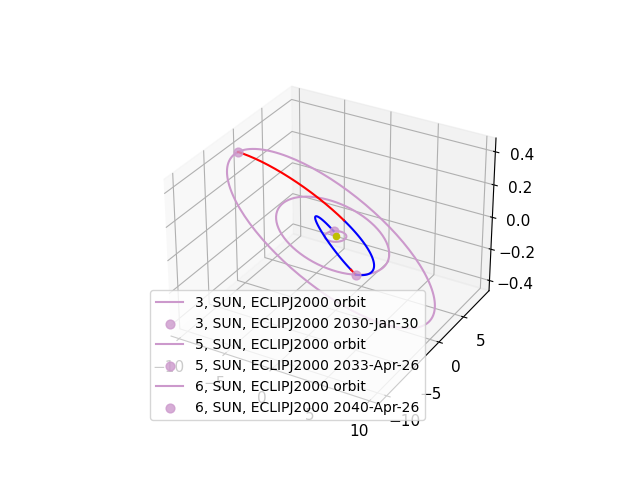

<Axes3DSubplot:>

In [103]:
prob_test.plot(xload[min_dsm_idx])

```
Communication blackout:
2043.11.01 - 2043.11.24
2044.11.11 - 2044.12.05
```

<IPython.core.display.Javascript object>


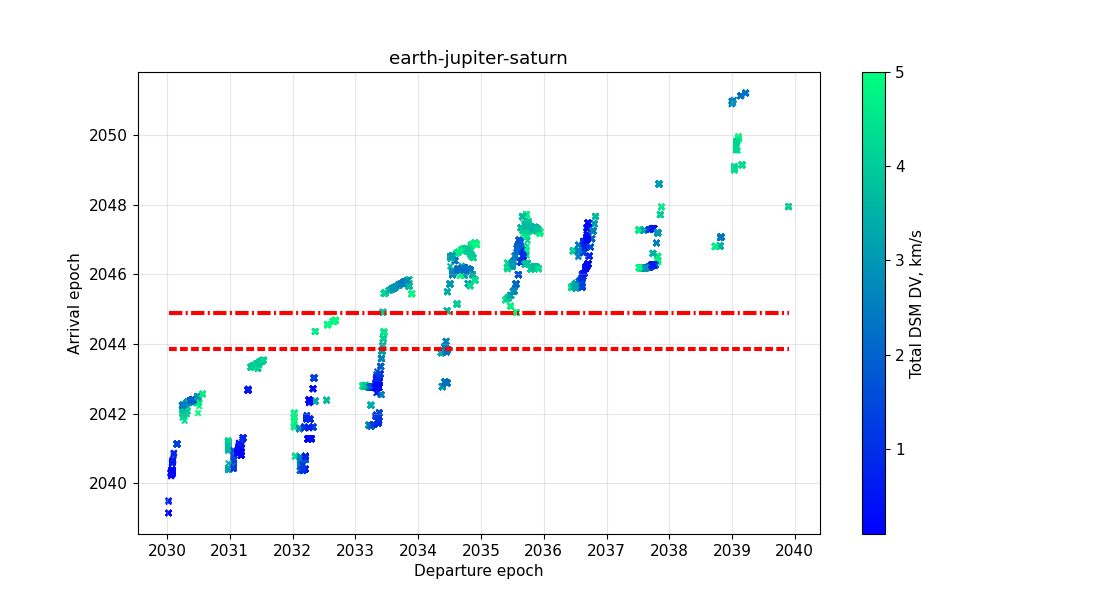

In [138]:
plt.rcParams["font.size"] = 11

fig, ax = plt.subplots(1,1,figsize=(11,6))

im0 = ax.scatter(porkchop_return['t0_matplotlib'], porkchop_return['tf_matplotlib'],#*pk.DAY2YEAR, 
                 c=porkchop_return['dsm_total']/1e3, cmap='winter', s=15, marker='x', 
                 vmax=max_dsm_total/1e3
)

# first blackout
ax.hlines(
    [
        np.datetime64(datetime.datetime.strptime("2043-11-01", '%Y-%m-%d')),
        np.datetime64(datetime.datetime.strptime("2043-11-24", '%Y-%m-%d')),
    ],
    min(porkchop_return['t0_matplotlib']), max(porkchop_return['t0_matplotlib']), color="red", linestyle="--"
)

# second blackout
ax.hlines(
    [
        np.datetime64(datetime.datetime.strptime("2044-11-11", '%Y-%m-%d')),
        np.datetime64(datetime.datetime.strptime("2044-12-05", '%Y-%m-%d')),
    ],
    min(porkchop_return['t0_matplotlib']), max(porkchop_return['t0_matplotlib']), color="red", linestyle="-."
)

fig.colorbar(im0, label='Total DSM DV, km/s')
ax.set_title(seq_name)
ax.set(xlabel="Departure epoch", ylabel="Arrival epoch")
ax.grid(True, alpha=0.3)

plt.show()

In [129]:
plt.savefig("./plots/seq_"+seq_name+"_dsm_dv.png")

<IPython.core.display.Javascript object>


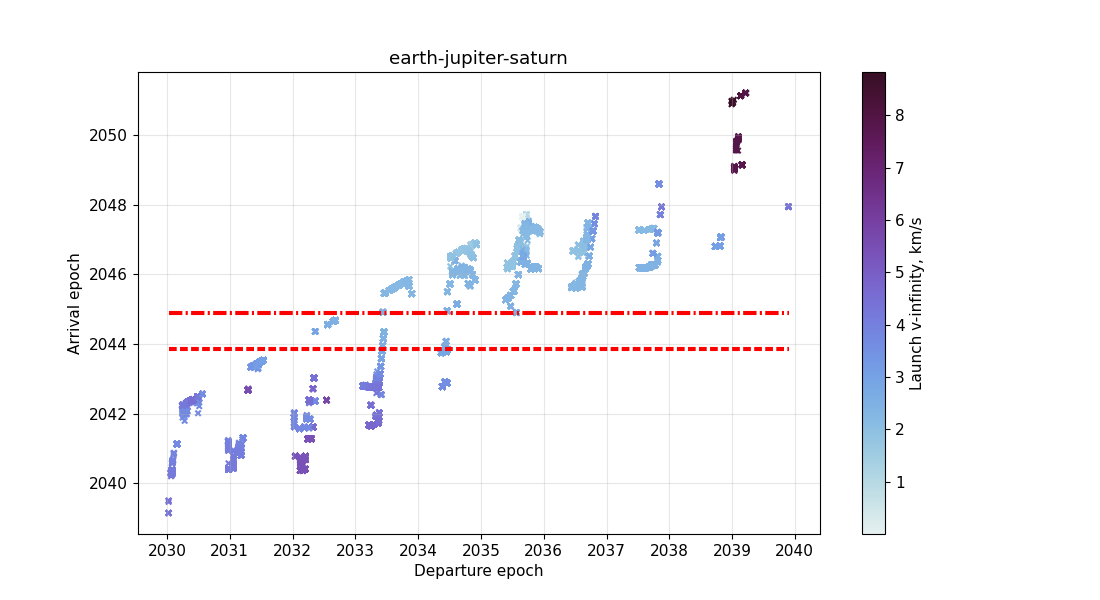

In [135]:
plt.rcParams["font.size"] = 11

fig, ax = plt.subplots(1,1,figsize=(11,6))

im0 = ax.scatter(porkchop_return['t0_matplotlib'], porkchop_return['tf_matplotlib'],#*pk.DAY2YEAR, 
                     c=porkchop_return['launch_deltaV']/1e3, cmap=cm.dense, s=15, marker='x')

# first blackout
ax.hlines(
    [
        np.datetime64(datetime.datetime.strptime("2043-11-01", '%Y-%m-%d')),
        np.datetime64(datetime.datetime.strptime("2043-11-24", '%Y-%m-%d')),
    ],
    min(porkchop_return['t0_matplotlib']), max(porkchop_return['t0_matplotlib']), color="red", linestyle="--"
)

# second blackout
ax.hlines(
    [
        np.datetime64(datetime.datetime.strptime("2044-11-11", '%Y-%m-%d')),
        np.datetime64(datetime.datetime.strptime("2044-12-05", '%Y-%m-%d')),
    ],
    min(porkchop_return['t0_matplotlib']), max(porkchop_return['t0_matplotlib']), color="red", linestyle="-."
)

fig.colorbar(im0, label='Launch v-infinity, km/s')
ax.set_title(seq_name)
ax.set(xlabel="Departure epoch", ylabel="Arrival epoch")
ax.grid(True, alpha=0.3)

plt.show()

In [136]:
plt.savefig("./plots/seq_"+seq_name+"_vinf_arr.png")

In [102]:
# plt.rcParams["font.size"] = 11

# fig, ax = plt.subplots(1,1,figsize=(11,4))

# im0 = ax.scatter(porkchop_return['t0_matplotlib'], porkchop_return['tof_total']*pk.DAY2YEAR, 
#                      c=porkchop_return['dsm_total']/1e3, cmap='winter', s=15, marker='x')

# fig.colorbar(im0, label='Total DSM DV, km/s')
# ax.set_title(seq_name)
# ax.set(xlabel="Departure, year", ylabel="TOF, year")
# ax.grid(True, alpha=0.3)

# plt.show()

### Index of solution

In [ ]:
plt.rcParams["font.size"] = 11

fig, ax = plt.subplots(1,1,figsize=(11,4))

im0 = ax.scatter(porkchop_return['t0_matplotlib'], porkchop_return['tof_total']*pk.DAY2YEAR, 
                     c=porkchop_return['idx'], cmap='plasma', s=15, marker='x')

fig.colorbar(im0, label='Index')
ax.set_title(seq_name)
ax.set(xlabel="Departure, year", ylabel="TOF, year")

plt.show()